In [35]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os
import datetime

In [2]:
def load(name):
    # Loads the videos and converts the labels into one-hot encoding for Keras
    X = np.load(name + ".npy")
    y = np.load(name + "-labels.npy")
    y_one_hot_encoded = np.zeros([y.shape[0], np.unique(y).size])
    y_one_hot_encoded[range(y.shape[0]), y] = 1
    return X, y_one_hot_encoded

In [6]:
epochs = 10
batch_size = 64
learning_rate = 1e-5

# Loads the preprocessed datasets
print("Dataset loading..", end = " ")
X_train, y_train = load("training")
X_val, y_val = load("validation")
X_test, y_test = load("test")
print("Dataset loaded!")

Dataset loading.. Dataset loaded!


In [41]:
model = Sequential()
model.add(ConvLSTM2D(32, (3,3), data_format = "channels_first", input_shape = (45,3,24,24)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation = "softmax"))
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning_rate), metrics=["accuracy"])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 32, 22, 22)        40448     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 22, 22)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               3965184   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 13)                3341      
Total params: 4,008,973
Trainable params: 4,008,973
Non-trainable params: 0
___________________________________________

In [42]:
# settings for reducing the learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 0.0001, verbose = 1)

# Training the model on the training set, with early stopping using the validation set
callbacks = [EarlyStopping(patience = 7), reduce_lr]

In [43]:
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = (X_val, y_val), callbacks = callbacks)

Epoch 1/10
120/120 [==============================] - 1413s 12s/step - loss: 2.0638 - accuracy: 0.3787 - val_loss: 1.7835 - val_accuracy: 0.4353
Epoch 2/10
120/120 [==============================] - 1282s 11s/step - loss: 1.7128 - accuracy: 0.4648 - val_loss: 1.5715 - val_accuracy: 0.5073
Epoch 3/10
102/120 [========================>.....] - ETA: 3:08 - loss: 1.5709 - accuracy: 0.5026

KeyboardInterrupt: 

In [8]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_test = np.argmax(y_test, axis = 1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       123
           1       0.58      0.40      0.47        85
           2       0.60      0.30      0.40        10
           3       0.95      0.95      0.95       260
           4       0.69      0.67      0.68       147
           5       0.67      0.20      0.31        10
           6       0.68      0.43      0.53        30
           7       0.71      0.46      0.56        84
           8       0.54      0.37      0.44        52
           9       0.57      0.63      0.60       156
          10       0.76      0.83      0.80       424
          11       0.14      0.11      0.12         9
          12       0.58      0.76      0.66       110

    accuracy                           0.72      1500
   macro avg       0.62      0.52      0.55      1500
weighted avg       0.72      0.72      0.71      1500

[[ 84   2   0   0   1   0   0   1   0   9  19   0   7]
 [  4  34   1   1   2   

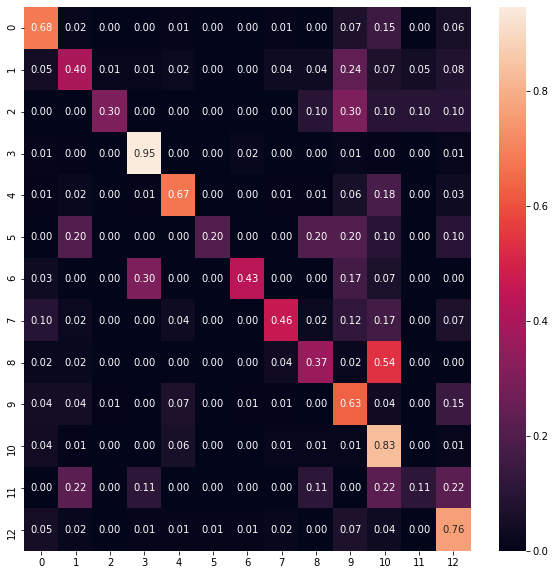

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f')